In [50]:
from rdflib import Graph, RDF, RDFS, Namespace, Literal, URIRef
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt


## 1 Query game genre

In [66]:
sparql = SPARQLWrapper("http://localhost:7200/repositories/repo-fandom")
sparql.setQuery("""
PREFIX fdo: <http://fandom.com/ontology/>
PREFIX fdr: <http://fandom.com/resource/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?game ?gameLabel ?genreLabel
WHERE { 
  ?game a fdo:Game . # ensure entity is a game
  ?game rdfs:label ?gameLabel . # get the label of the game
  
  # working with different predicates
  { ?game fdo:genres ?genre . } 
  UNION 
  { ?game fdo:genre ?genre . }
  UNION
  { ?game fdo:hasGenre ?genre . }
  UNION
  { ?game fdr:genres ?genre . }
  
  # get the genre label
  ?genre rdfs:label ?genreLabel .
  
  # filter by genre label, like roguelike, sandbox
  FILTER (regex(str(?genreLabel), "roguelike", "i")) 
}
""")
sparql.setReturnFormat(JSON)

results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
    game = result["game"]["value"]
    gameLabel = result["gameLabel"]["value"] 
    genreLabel = result["genreLabel"]["value"] 
    data.append([game, gameLabel, genreLabel])

df = pd.DataFrame(data, columns=["Game", "Game Label", "Genre Label"])
df

,Game,Game Label,Genre Label
0,http://fandom.com/resource/20XX,20XX,"Roguelike, Action, Platformer"
1,http://fandom.com/resource/30XX,30XX,Roguelike
2,http://fandom.com/resource/RAD,RAD,Roguelike
3,http://fandom.com/resource/Balatro,Balatro,"Roguelike, Deckbuilder"
4,http://fandom.com/resource/Black_Future_2788,Black Future '88,Action roguelike
5,http://fandom.com/resource/DandyAce_Wiki,Dandy Ace,Action Roguelike
6,http://fandom.com/resource/Loot_River,Loot River,"Indie action roguelike, dark fantasy"
7,http://fandom.com/resource/Roguebook,Roguebook,Roguelike deck-builder
8,http://fandom.com/resource/Sundered,Sundered,"Roguelike, Metroidvania"
9,http://fandom.com/resource/Wildfrost,Wildfrost,"Fantasy, Roguelike deckbuilder, Card Battler"


## 2 Query by voice actors

In [67]:
sparql = SPARQLWrapper("http://localhost:7200/repositories/repo-fandom")
sparql.setQuery("""
PREFIX fdo: <http://fandom.com/ontology/>
PREFIX fdr: <http://fandom.com/resource/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?gameLabel ?character ?characterLabel ?voiceActor 
WHERE { 
  ?character a fdo:Character . # ensure entity is a character
  ?character rdfs:label ?characterLabel . # get the label of the character
  
  # get the voice actor
  { ?character fdo:hasVoiceActor ?voiceActor . }
  UNION
  { ?character fdo:voicedBy ?voiceActor . }
  
  # get the game the character appears in
  { ?character fdo:appearsIn ?game . }
  UNION
  { ?character fdo:appearsInGame ?game . }
  ?game rdfs:label ?gameLabel .
}
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
    gameLabel = result["gameLabel"]["value"] 
    character = result["character"]["value"] 
    characterLabel = result["characterLabel"]["value"] 
    voiceActor = result["voiceActor"]["value"] 
    data.append([gameLabel, character, characterLabel, voiceActor])

df = pd.DataFrame(data, columns=["Game Label", "Character", "Character Label", "Voice Actor"])
df

,Game Label,Character,Character Label,Voice Actor
0,Medal of Honor: European Assault,http://fandom.com/resource/28th_Infantry_Division,28th Infantry Division,http://fandom.com/resource/Matthew
1,"Medal of Honor: Allied Assault, Medal of Honor...",http://fandom.com/resource/29th_Infantry_Division,29th Infantry Division,http://fandom.com/resource/Matthew
2,Pokémon the Series: The Beginning,http://fandom.com/resource/AJOn_hand,A.J.,http://fandom.com/resource/MaddieBlaustein
3,Pokémon Generations,http://fandom.com/resource/AZ_Generations,AZ,http://fandom.com/resource/KeithSilverstein
4,Pokémon Generations,http://fandom.com/resource/AZ_Generations,AZ,http://fandom.com/resource/TakayaHashi
...,...,...,...,...
154,"Titanfall 2, Stories from the Outlands, Apex L...",http://fandom.com/resource/Viper,Viper,http://fandom.com/resource/EvanBoymel
155,"Medal of Honor, Medal of Honor: Warfighter",http://fandom.com/resource/Voodoo,Voodoo,http://fandom.com/resource/JonBruno
156,Chapter 2,http://fandom.com/resource/Dolores,Dolores,http://fandom.com/resource/JeanRudaHabrukowich
157,"Chapter 1, Chapters 2-3, Chapter 4",http://fandom.com/resource/Rose,Rose,http://fandom.com/resource/ClareCorbett


## 3 Query what genre a voice actor is in

In [69]:
sparql = SPARQLWrapper("http://localhost:7200/repositories/repo-fandom")
sparql.setQuery("""
PREFIX fdo: <http://fandom.com/ontology/>
PREFIX fdr: <http://fandom.com/resource/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?voiceActor ?character ?characterLabel ?game ?gameLabel ?genreLabel
WHERE { 
  # ensure entity is a character and get the label of the character
  ?character a fdo:Character . 
  ?character rdfs:label ?characterLabel .
  
  # get the voice actor
  { ?character fdo:hasVoiceActor ?voiceActor . }
  UNION
  { ?character fdo:voicedBy ?voiceActor . }
  
  # get the game the character appears in
  { ?character fdo:appearsIn ?game . }
  UNION
  { ?character fdo:appearsInGame ?game . }
  
  # get the label of the game
  ?game rdfs:label ?gameLabel .
  
  # working with different predicates for genre
  { ?game fdo:genres ?genre . } 
  UNION 
  { ?game fdo:genre ?genre . }
  UNION
  { ?game fdo:hasGenre ?genre . }
  UNION
  { ?game fdr:genres ?genre . }
  
  # get the genre label
  ?genre rdfs:label ?genreLabel .
}
""")

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
    voiceActor = result["voiceActor"]["value"] 
    character = result["character"]["value"] 
    characterLabel = result["characterLabel"]["value"] 
    game = result["game"]["value"] 
    gameLabel = result["gameLabel"]["value"] 
    genreLabel = result["genreLabel"]["value"] 
    data.append([voiceActor, character, characterLabel, game, gameLabel, genreLabel])

df = pd.DataFrame(data, columns=["Voice Actor", "Character", "Character Label", "Game", "Game Label", "Genre Label"])
df

,Voice Actor,Character,Character Label,Game,Game Label,Genre Label
0,http://fandom.com/resource/NatsumiFujiwaraJapa...,http://fandom.com/resource/Asuma_Soga,Asuma Soga,http://fandom.com/resource/AnonymousCode,Anonymous;Code,Visual novel
1,http://fandom.com/resource/TomokazuSugitaYChang,http://fandom.com/resource/Cross_Yumikawa,Cross Yumikawa,http://fandom.com/resource/AnonymousCode,Anonymous;Code,Visual novel
2,http://fandom.com/resource/EmiLo,http://fandom.com/resource/Iroha_Kyogoku,Iroha Kyogoku,http://fandom.com/resource/AnonymousCode,Anonymous;Code,Visual novel
3,http://fandom.com/resource/MarikoHonda,http://fandom.com/resource/Iroha_Kyogoku,Iroha Kyogoku,http://fandom.com/resource/AnonymousCode,Anonymous;Code,Visual novel
4,http://fandom.com/resource/KariWahlgren,http://fandom.com/resource/Elena_Ivanova,Elena Ivanova,http://fandom.com/resource/Vanquish,Vanquish,Third-person shooter
5,http://fandom.com/resource/BenitoMartinez,http://fandom.com/resource/Professor_Francois_...,Professor Francois Candide,http://fandom.com/resource/Vanquish,Vanquish,Third-person shooter
6,http://fandom.com/resource/StevenBlum,http://fandom.com/resource/Robert_Burns,Robert Burns,http://fandom.com/resource/Vanquish,Vanquish,Third-person shooter
7,http://fandom.com/resource/GideonEmeryEnglishn...,http://fandom.com/resource/Sam_Gideon,Sam Gideon,http://fandom.com/resource/Vanquish,Vanquish,Third-person shooter
8,http://fandom.com/resource/MarcWorden,http://fandom.com/resource/Victor_Zaitsev,Victor Zaitsev,http://fandom.com/resource/Vanquish,Vanquish,Third-person shooter


## 4 Query everything within a certain game

In [70]:
sparql = SPARQLWrapper("http://localhost:7200/repositories/repo-fandom")
sparql.setQuery("""
PREFIX fdo: <http://fandom.com/ontology/>
PREFIX fdr: <http://fandom.com/resource/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?subject ?label ?comment
WHERE { 
  ?subject rdfs:label ?label .
  OPTIONAL { ?subject rdfs:comment ?comment . }
  
  # filter labels or comments containing "LEGO City"
  FILTER (regex(str(?label), "LEGO City", "i") || regex(str(?comment), "LEGO City", "i"))
}
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
    subject = result["subject"]["value"] 
    label = result["label"]["value"] 
    comment = result["comment"]["value"] if "comment" in result else "N/A"
    data.append([subject, label, comment])

df = pd.DataFrame(data, columns=["Subject", "Label", "Comment"])
df

,Subject,Label,Comment
0,http://fandom.com/resource/Air_Host,Air Host,Air Host is a non-playable character in LEGO C...
1,http://fandom.com/resource/LEGOCityUndercover,LEGO City Undercover,N/A
2,http://fandom.com/resource/Albatross_Island,Albatross Island,Albatross Island is a district featured in LEG...
3,http://fandom.com/resource/LEGOCityUndercoverT...,LEGO City Undercover: The Chase Begins,N/A
4,http://fandom.com/resource/Auburn,Auburn,"Auburn is a district in LEGO City, featured in..."
5,http://fandom.com/resource/Apollo_Island,Apollo Island,Apollo Island is a district featured in LEGO C...
6,http://fandom.com/resource/Athena,Athena,Athena is a compact vehicle found in LEGO City...
7,http://fandom.com/resource/Art_Gallery,Art Gallery,An Art Gallery in LEGO City Undercover serving...
8,http://fandom.com/resource/Attract_Bricks,Attract Bricks,Attract Bricks are collectibles in LEGO City U...
9,http://fandom.com/resource/Attract_Studs,Attract Studs,Attract Studs is a collectible item in LEGO Ci...


## 5 Query both game and steamdb data

                                          Game           Game Label  Current  \
4916  http://example.org/PUBG%3A_BATTLEGROUNDS  PUBG: BATTLEGROUNDS   678431   
1025   http://example.org/Black_Myth%3A_Wukong   Black Myth: Wukong   178923   
4934               http://example.org/Palworld             Palworld    24412   
1611       http://example.org/Counter-Strike_2     Counter-Strike 2  1369985   
3997               http://example.org/Lost_Ark             Lost Ark    21976   
2106                 http://example.org/Dota_2               Dota 2   612187   
1729         http://example.org/Cyberpunk_2077       Cyberpunk 2077    37710   
2273             http://example.org/ELDEN_RING           ELDEN RING    49050   
889                  http://example.org/Banana               Banana   426998   
4606  http://example.org/New_World%3A_Aeternum  New World: Aeternum    40121   

      24h Peak  All-Time Peak  
4916    700726        3257248  
1025    178923        2415714  
4934     24412        2

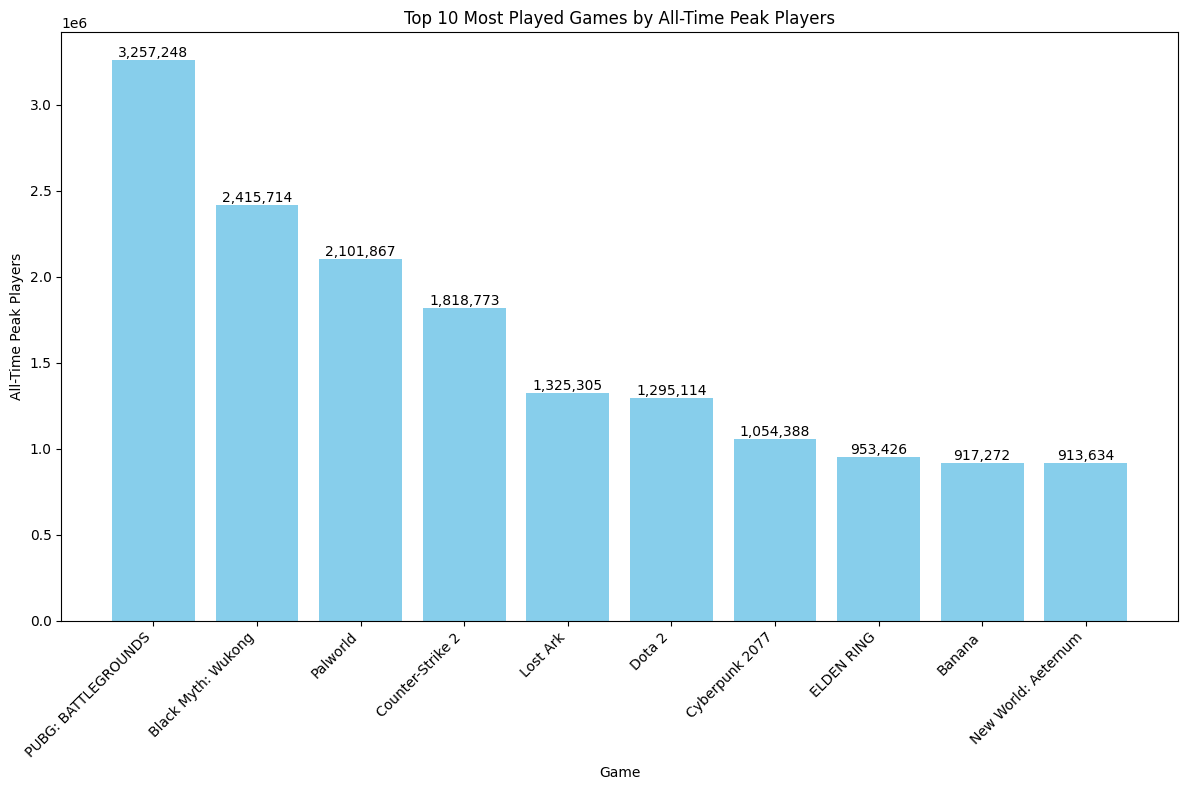

In [71]:
sparql = SPARQLWrapper("http://localhost:7200/repositories/repo-fandom")
sparql.setQuery("""
PREFIX ex: <http://example.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?game ?gameLabel ?current ?peak24h ?allTimePeak
WHERE { 
  ?game a ex:Game .
  ?game ex:name ?gameLabel .
  ?game ex:current ?current .
  ?game ex:peak_24h ?peak24h .
  ?game ex:all_time_peak ?allTimePeak .
}
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
    game = result["game"]["value"] 
    gameLabel = result["gameLabel"]["value"] 
    current = int(result["current"]["value"]) 
    peak24h = int(result["peak24h"]["value"]) 
    allTimePeak = int(result["allTimePeak"]["value"]) 
    data.append([game, gameLabel, current, peak24h, allTimePeak])

df = pd.DataFrame(data, columns=["Game", "Game Label", "Current", "24h Peak", "All-Time Peak"])

top_10_games = df.sort_values(by="All-Time Peak", ascending=False).head(10)

print(top_10_games)

plt.figure(figsize=(12, 8))
plt.bar(top_10_games["Game Label"], top_10_games["All-Time Peak"], color='skyblue')
plt.xlabel('Game')
plt.ylabel('All-Time Peak Players')
plt.title('Top 10 Most Played Games by All-Time Peak Players')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for index, value in enumerate(top_10_games["All-Time Peak"]):
    plt.text(index, value, f'{value:,}', ha='center', va='bottom')

plt.show()



## 6 Query race of characters

                                         Game  Character Count
0  http://fandom.com/resource/GrandTheftAutoV               12
1   http://fandom.com/resource/FreedomPlanet2                6
2         http://fandom.com/resource/Prey2017                5


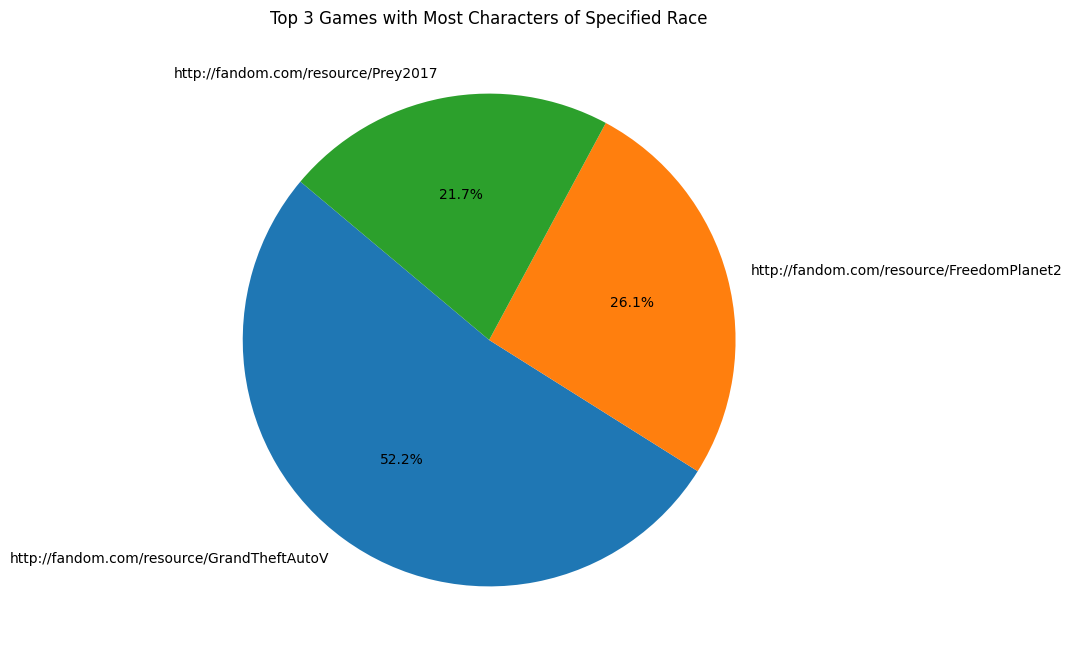

In [72]:
sparql = SPARQLWrapper("http://localhost:7200/repositories/repo-fandom")
sparql.setQuery("""
PREFIX fdo: <http://fandom.com/ontology/>
PREFIX fdr: <http://fandom.com/resource/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?game (COUNT(?character) AS ?characterCount)
WHERE { 
  ?character a fdo:Character .
  ?character fdo:hasRace ?race .
  { ?character fdo:appearsIn ?game . }
  UNION
  { ?character fdo:appearsInGame ?game . }
  UNION
  { ?character fdo:hasAppearanceIn ?game . }
  UNION
  { ?character fdo:appearance ?game . }
}
GROUP BY ?game
ORDER BY DESC(?characterCount)
LIMIT 3
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
    game = result["game"]["value"] 
    characterCount = int(result["characterCount"]["value"]) if "characterCount" in result else 0
    data.append([game, characterCount])

df = pd.DataFrame(data, columns=["Game", "Character Count"])

print(df)

plt.figure(figsize=(8, 8))
plt.pie(df['Character Count'], labels=df['Game'], autopct='%1.1f%%', startangle=140)
plt.title('Top 3 Games with Most Characters of Specified Race')
plt.show()

## 7 Query with wikidata

In [61]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt

local_sparql = SPARQLWrapper("http://localhost:7200/repositories/repo-fandom")
local_sparql.setQuery("""
PREFIX ex: <http://example.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?game ?gameLabel ?current ?peak24h ?allTimePeak
WHERE { 
  ?game a ex:Game .
  ?game ex:name ?gameLabel .
  ?game ex:current ?current .
  ?game ex:peak_24h ?peak24h .
  ?game ex:all_time_peak ?allTimePeak .
}
""")
local_sparql.setReturnFormat(JSON)
local_results = local_sparql.query().convert()

wikidata_sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
wikidata_sparql.setQuery("""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>

SELECT DISTINCT ?game ?gameLabel ?developerLabel ?publisherLabel ?releaseDate
WHERE {
  ?game wdt:P31 wd:Q7889 ;  # instance of video game
        rdfs:label "Grand Theft Auto V"@en ;
        wdt:P178 ?developer ;  # developer
        wdt:P123 ?publisher ;  # publisher
        wdt:P577 ?releaseDate .  # release date
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
""")
wikidata_sparql.setReturnFormat(JSON)
wikidata_results = wikidata_sparql.query().convert()

local_data = []
for result in local_results["results"]["bindings"]:
    game = result["game"]["value"] if "game" in result else "N/A"
    gameLabel = result["gameLabel"]["value"] if "gameLabel" in result else "N/A"
    current = int(result["current"]["value"]) if "current" in result else 0
    peak24h = int(result["peak24h"]["value"]) if "peak24h" in result else 0
    allTimePeak = int(result["allTimePeak"]["value"]) if "allTimePeak" in result else 0
    local_data.append([game, gameLabel, current, peak24h, allTimePeak])

wikidata_data = []
for result in wikidata_results["results"]["bindings"]:
    game = result["game"]["value"] if "game" in result else "N/A"
    gameLabel = result["gameLabel"]["value"] if "gameLabel" in result else "N/A"
    developerLabel = result["developerLabel"]["value"] if "developerLabel" in result else "N/A"
    publisherLabel = result["publisherLabel"]["value"] if "publisherLabel" in result else "N/A"
    releaseDate = result["releaseDate"]["value"] if "releaseDate" in result else "N/A"
    wikidata_data.append([game, gameLabel, developerLabel, publisherLabel, releaseDate])

local_df = pd.DataFrame(local_data, columns=["Game", "Game Label", "Current", "24h Peak", "All-Time Peak"])
wikidata_df = pd.DataFrame(wikidata_data, columns=["Game", "Game Label", "Developer", "Publisher", "Release Date"])

merged_df = pd.merge(local_df, wikidata_df, on="Game Label", how="inner")

merged_df = merged_df.drop(columns=["Game_y"])
merged_df = merged_df.rename(columns={"Game_x": "Game"})
merged_df = merged_df.drop_duplicates(subset=["Game Label"])

merged_df

,Game,Game Label,Current,24h Peak,All-Time Peak,Developer,Publisher,Release Date
0,http://example.org/Grand_Theft_Auto_V,Grand Theft Auto V,153040,153040,364548,Rockstar North,Softclub,2022-03-15T00:00:00Z
